# 🎿 Visitor Forecast Model - Training Notebook

Train and register the **VISITOR_FORECASTER** model.

## Scalable Architecture

```
config/features/
├── base.yaml              ← Shared feature definitions
├── visitor_forecast.yaml  ← Model-specific config + query
├── wait_time.yaml         ← (same pattern for other models)
└── staffing.yaml

models/
└── feature_engineer.py    ← Generic, YAML-driven FeatureEngineer
```

## Workflow
1. Load config: `FeatureEngineer.from_config("visitor_forecast")`
2. Run query: `fe.get_training_query()` (joins FACT_WEATHER!)
3. Engineer features: `fe.engineer(df)`
4. Train with: `fe.get_hyperparams()`
5. Register to Model Registry


## 1. Setup & Imports


In [1]:
# Standard imports
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Add parent directory for module imports
sys.path.insert(0, '..')

# YAML-driven FeatureEngineer - same class works for any model!
from models.feature_engineer import FeatureEngineer

# ML imports
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Snowflake imports
from snowflake.snowpark.context import get_active_session
from snowflake.snowpark import Session

plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Imports loaded")
print(f"   XGBoost: {xgb.__version__}")


✅ Imports loaded
   XGBoost: 3.0.1


In [2]:
# Get Snowflake session (works in Snowsight notebooks)
try:
    session = get_active_session()
    print(f"✅ Connected to Snowflake")
    print(f"   Database: {session.get_current_database()}")
    print(f"   Schema: {session.get_current_schema()}")
    print(f"   Warehouse: {session.get_current_warehouse()}")
except:
    # Fallback for local development
    print("⚠️ Running locally - using connection config")
    import toml
    from pathlib import Path
    
    config_path = Path.home() / '.snowflake' / 'config.toml'
    sf_config = toml.load(config_path)
    conn_config = sf_config.get('connections', {}).get('snowflake_agents', {})
    
    session = Session.builder.configs({
        'account': conn_config.get('account'),
        'user': conn_config.get('user'),
        'password': conn_config.get('password'),
        'database': 'SKI_RESORT_DB',
        'schema': 'MARTS',
        'warehouse': conn_config.get('warehouse', 'COMPUTE_WH')
    }).create()
    print(f"✅ Connected locally")


⚠️ Running locally - using connection config
✅ Connected locally


## 2. Load & Explore Training Data



### LOAD CONFIG & DATA (from YAML - single source of truth)


In [3]:
# Load FeatureEngineer from YAML config
# Same pattern for any model: FeatureEngineer.from_config("wait_time"), etc.
fe = FeatureEngineer.from_config("visitor_forecast")

print(f"📋 Model: {fe.model_name}")
print(f"   Target: {fe.target_column}")
print(f"   Quality gates: R² ≥ {fe.quality_gates.get('min_r2', 'N/A')}, MAE ≤ {fe.quality_gates.get('max_mae', 'N/A')}")
print(fe.describe())

# Get training query (joins FACT_WEATHER for real weather data!)
query = fe.get_training_query(
    database="SKI_RESORT_DB", 
    schema="MARTS", 
    years_back=4
)
print("Query:")
print(query)

df = session.sql(query).to_pandas()
print(f"\n✅ Loaded {len(df)} days of visitor data")
print(f"   Date range: {df['FULL_DATE'].min()} to {df['FULL_DATE'].max()}")
print(f"   Columns: {list(df.columns)}")
df.head()

📋 Model: VISITOR_FORECASTER
   Target: UNIQUE_VISITORS
   Quality gates: R² ≥ 0.7, MAE ≤ 200

Feature Engineer: VISITOR_FORECASTER
  Target: UNIQUE_VISITORS
  Date Column: FULL_DATE
  Total Features: 37

  Feature Types:
    categorical: 1 features
    column: 8 features
    date_extract: 2 features
    one_hot: 19 features

  Lag Features: [7, 14, 21, 28]
  Rolling Features: [7, 14, 30] (mean)

  Quality Gates:
    R² ≥ 0.7
    MAE ≤ 200
    MAPE ≤ 25.0%

Query:
WITH daily_weather AS (
    -- Aggregate weather across mountain zones to get one row per date
    SELECT
        DATE_KEY,
        MAX(SNOW_CONDITION) as SNOW_CONDITION,  -- Best condition that day
        SUM(SNOWFALL_INCHES) as SNOWFALL_INCHES,  -- Total snowfall
        AVG(BASE_DEPTH_INCHES) as BASE_DEPTH_INCHES,
        AVG(AVG_TEMP_F) as AVG_TEMP_F,
        MAX(WIND_SPEED_MPH) as WIND_SPEED_MPH,  -- Worst wind
        MAX(CASE WHEN IS_POWDER_DAY THEN 1 ELSE 0 END) as IS_POWDER_DAY,
        MAX(CASE WHEN IS_HIGH_WIND THE

,FULL_DATE,DAY_OF_WEEK,MONTH,IS_WEEKEND,IS_HOLIDAY,SNOW_CONDITION,SNOWFALL_INCHES,BASE_DEPTH_INCHES,AVG_TEMP_F,WIND_SPEED_MPH,IS_POWDER_DAY,IS_HIGH_WIND,UNIQUE_VISITORS
0,2021-12-08,3,12,False,False,Groomed,9.95,103.2300,25.0250,15.8,0,0,407
1,2021-12-09,4,12,False,False,Powder,37.70,110.7275,20.7625,27.0,1,1,485
2,2021-12-10,5,12,False,False,Fresh Snow,35.79,112.0950,20.9750,5.5,1,0,493
3,2021-12-11,6,12,True,False,Powder,56.33,121.8100,23.4125,4.9,1,0,585
4,2021-12-12,0,12,True,False,Powder,42.06,127.0100,22.2500,9.4,1,0,673


In [4]:
# Basic statistics
print("📊 Visitor Statistics")
print("=" * 50)
print(f"Total days: {len(df)}")
print(f"Average daily visitors: {df['UNIQUE_VISITORS'].mean():,.0f}")
print(f"Median daily visitors: {df['UNIQUE_VISITORS'].median():,.0f}")
print(f"Min visitors: {df['UNIQUE_VISITORS'].min():,}")
print(f"Max visitors: {df['UNIQUE_VISITORS'].max():,}")
print(f"Std dev: {df['UNIQUE_VISITORS'].std():,.0f}")

print("\n📊 Weekend vs Weekday")
print("=" * 50)
weekend_stats = df.groupby('IS_WEEKEND')['UNIQUE_VISITORS'].agg(['mean', 'std', 'count'])
weekend_stats.index = ['Weekday', 'Weekend']
print(weekend_stats)


📊 Visitor Statistics
Total days: 725
Average daily visitors: 568
Median daily visitors: 493
Min visitors: 118
Max visitors: 2,797
Std dev: 393

📊 Weekend vs Weekday
               mean         std  count
Weekday  490.947674  310.574549    516
Weekend  759.918660  498.079801    209


## 3. Feature Engineering


In [5]:
# Feature engineering - all logic defined in YAML
df_features = fe.engineer(df)
feature_cols = fe.get_feature_columns(df_features)  # Only features that exist in data

print(f"✅ Features engineered: {len(df_features)} rows, {len(feature_cols)} features")
print(f"   Features: {feature_cols}")


✅ Features engineered: 695 rows, 37 features
   Features: ['day_of_week', 'month', 'is_weekend', 'is_holiday', 'snowfall_inches', 'base_depth_inches', 'avg_temp_f', 'wind_speed_mph', 'is_powder_day', 'is_high_wind', 'snow_condition_encoded', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'lag_7', 'lag_14', 'lag_21', 'lag_28', 'rolling_7_mean', 'rolling_14_mean', 'rolling_30_mean']


## 4. Train XGBoost Model


In [6]:
# ============================================================================
# TRAIN/TEST SPLIT (using FeatureEngineer)
# ============================================================================
X_train, X_test, y_train, y_test = fe.get_train_test_split(df_features, test_ratio=0.2)

print(f"📊 Data Split (Time-based)")
print(f"   Training: {len(X_train)} samples")
print(f"   Test: {len(X_test)} samples")
print(f"   Features: {len(feature_cols)}")


📊 Data Split (Time-based)
   Training: 556 samples
   Test: 139 samples
   Features: 37



### EXPERIMENT TRACKING SETUP


In [7]:
# ============================================================================
# EXPERIMENT TRACKING - TRAIN, EVALUATE, LOG (all in one run!)
# ============================================================================
from snowflake.ml.experiment import ExperimentTracking

exp = ExperimentTracking(session=session)
exp.set_experiment("visitor_forecast_experiments")
print("📊 Experiment: visitor_forecast_experiments")

# Hyperparameters from YAML config
hyperparams = fe.get_hyperparams()

# Keep as DataFrames with proper dtypes for XGBoost
X_train_df = X_train.astype(np.float64)
X_test_df = X_test.astype(np.float64)
y_train_np = y_train.values.astype(np.float64)
y_test_np = y_test.values.astype(np.float64)

# Also create numpy versions for metric calculations
X_train_np = X_train_df.values
X_test_np = X_test_df.values

# Run name for this experiment
run_name = f"xgb_visitor_forecast_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

# ============================================================================
# IMPORTANT: Everything inside `with` block - run closes when block ends!
# ============================================================================
with exp.start_run(run_name) as run:
    print(f"🏃 Started run: {run_name}")
    
    # 1. LOG HYPERPARAMETERS
    exp.log_params(hyperparams)
    exp.log_params({
        'feature_count': len(feature_cols),
        'train_samples': len(X_train_np),
        'test_samples': len(X_test_np)
    })
    print("   ✓ Parameters logged")
    
    # 2. TRAIN MODEL
    model = xgb.XGBRegressor(**{k: v for k, v in hyperparams.items()})
    
    print("🏋️ Training XGBoost model...")
    model.fit(
        X_train_df, y_train_np,
        eval_set=[(X_test_df, y_test_np)],
        verbose=True
    )
    exp.log_metric('best_iteration', model.best_iteration)
    print(f"   ✓ Model trained (best iteration: {model.best_iteration})")
    
    # 3. EVALUATE MODEL
    y_pred = model.predict(X_test_np)
    mae = mean_absolute_error(y_test_np, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_np, y_pred))
    mape = np.mean(np.abs((y_test_np - y_pred) / y_test_np)) * 100
    r2 = r2_score(y_test_np, y_pred)
    
    # 4. LOG METRICS (in same run!)
    test_metrics = {'mae': float(mae), 'rmse': float(rmse), 'mape': float(mape), 'r2': float(r2)}
    exp.log_metrics(test_metrics)
    
    print(f"\n📊 Model Performance (logged to experiment):")
    print(f"   MAE:  {mae:,.0f} visitors (±{mae/y_test_np.mean()*100:.1f}%)")
    print(f"   RMSE: {rmse:,.0f} visitors")
    print(f"   MAPE: {mape:.1f}%")
    print(f"   R²:   {r2:.4f}")
    
    # NOTE: We register the model in the Model Registry section below (with proper signatures)
    # exp.log_model() is optional here - skipping to avoid needing signatures twice
    
    print(f"\n✅ Run complete! All metrics logged to single run.")
    print(f"   📊 View in Snowsight: AI & ML → Experiments → visitor_forecast_experiments")


ExperimentTracking.__init__() is in private preview since 1.9.1. Do not use it in production. 


📊 Experiment: visitor_forecast_experiments
🏃 Started run: xgb_visitor_forecast_20251208_124044
   ✓ Parameters logged
🏋️ Training XGBoost model...
[0]	validation_0-rmse:272.64374
[1]	validation_0-rmse:261.34023
[2]	validation_0-rmse:251.24961
[3]	validation_0-rmse:241.48827
[4]	validation_0-rmse:231.74854
[5]	validation_0-rmse:223.08567
[6]	validation_0-rmse:214.72262
[7]	validation_0-rmse:207.34600
[8]	validation_0-rmse:200.05437
[9]	validation_0-rmse:193.83004
[10]	validation_0-rmse:187.18379
[11]	validation_0-rmse:181.29481
[12]	validation_0-rmse:176.14196
[13]	validation_0-rmse:170.83330
[14]	validation_0-rmse:165.97555
[15]	validation_0-rmse:161.00919
[16]	validation_0-rmse:155.55410
[17]	validation_0-rmse:151.06959
[18]	validation_0-rmse:146.92096
[19]	validation_0-rmse:142.83953
[20]	validation_0-rmse:139.18284
[21]	validation_0-rmse:134.96869
[22]	validation_0-rmse:132.22667
[23]	validation_0-rmse:129.29250
[24]	validation_0-rmse:126.91364
[25]	validation_0-rmse:124.37624
[26]	

## 5. Evaluate Model Performance

In [8]:
# Metrics already computed in experiment run above
# test_metrics dict is available: {'mae', 'rmse', 'mape', 'r2'}
print("📊 Model Performance Summary")
print("=" * 50)
print(f"   MAE:  {test_metrics['mae']:,.0f} visitors")
print(f"   RMSE: {test_metrics['rmse']:,.0f} visitors")
print(f"   MAPE: {test_metrics['mape']:.1f}%")
print(f"   R²:   {test_metrics['r2']:.4f}")
print(f"\n✅ All metrics logged to experiment run: {run_name}")

📊 Model Performance Summary
   MAE:  54 visitors
   RMSE: 89 visitors
   MAPE: 11.9%
   R²:   0.8865

✅ All metrics logged to experiment run: xgb_visitor_forecast_20251208_124044


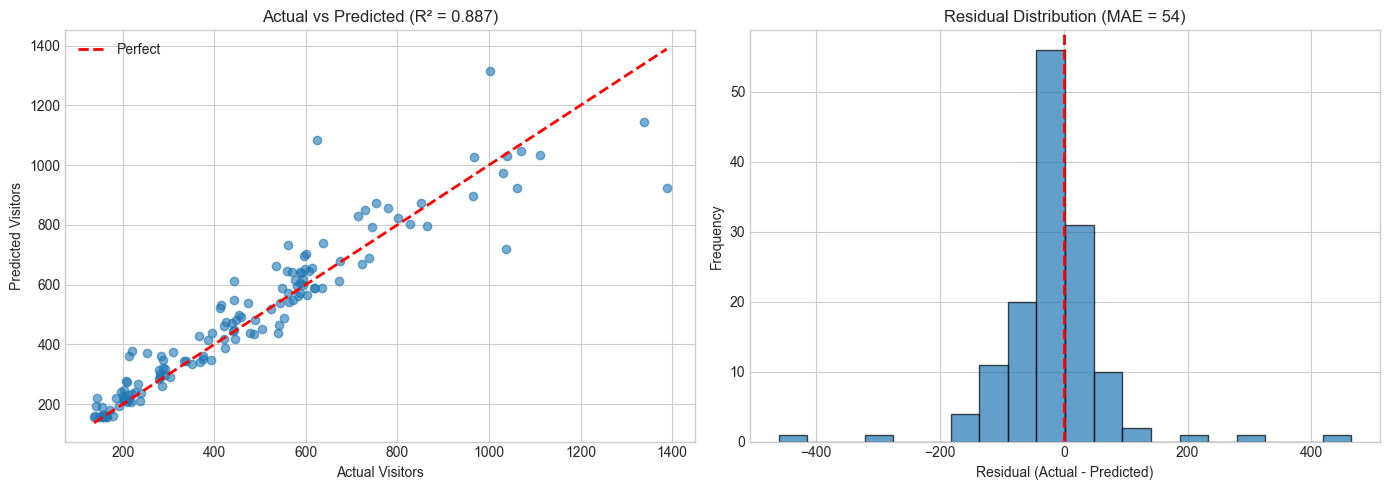

In [9]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test_np, y_pred, alpha=0.6)
axes[0].plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--', lw=2, label='Perfect')
axes[0].set_xlabel('Actual Visitors')
axes[0].set_ylabel('Predicted Visitors')
axes[0].set_title(f'Actual vs Predicted (R² = {r2:.3f})')
axes[0].legend()

# Residuals
residuals = y_test_np - y_pred
axes[1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Residual Distribution (MAE = {mae:,.0f})')

plt.tight_layout()
plt.show()


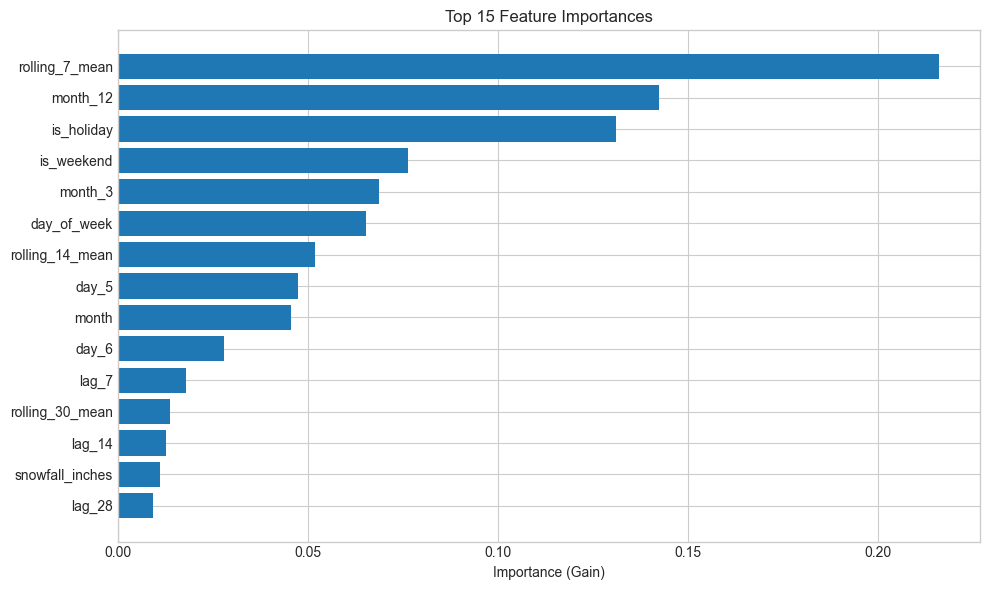

In [10]:
# Feature importance with actual names
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True).tail(15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance['feature'], importance['importance'])
ax.set_xlabel('Importance (Gain)')
ax.set_title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()


## 6. Register Model in Snowflake Model Registry


In [11]:
# Create model registry schema
session.sql("CREATE SCHEMA IF NOT EXISTS SKI_RESORT_DB.MODELS").collect()
print("✅ Model registry schema ready: SKI_RESORT_DB.MODELS")


✅ Model registry schema ready: SKI_RESORT_DB.MODELS



### STEP 1: Validate model meets quality bar BEFORE registering


In [12]:
# Quality gates from YAML config
print("📋 Model Quality Gate (from YAML)")
print("=" * 50)
print(f"   R² Score: {test_metrics['r2']:.4f} (threshold: ≥ {fe.quality_gates.get('min_r2')})")
print(f"   MAE:      {test_metrics['mae']:.0f} (threshold: ≤ {fe.quality_gates.get('max_mae')})")

if fe.passes_quality_gates(test_metrics['r2'], test_metrics['mae'], test_metrics.get('mape')):
    print("✅ Model passes quality gate!")
else:
    raise ValueError("Model does not meet quality thresholds. Do not register.")


📋 Model Quality Gate (from YAML)
   R² Score: 0.8865 (threshold: ≥ 0.7)
   MAE:      54 (threshold: ≤ 200)
✅ Model passes quality gate!



### STEP 2: Retrain on ALL data for production deployment


In [13]:
print("\n🔄 Retraining on FULL dataset for production...")

# Combine train + test for final model (use DataFrames)
import pandas as pd
X_full_df = pd.concat([X_train_df, X_test_df], ignore_index=True)
X_full = X_full_df.values
y_full = np.concatenate([y_train_np, y_test_np])

print(f"   Training samples: {len(X_train_np)} → {len(X_full)} (added {len(X_test_np)} test samples)")

# Retrain with same hyperparameters (use best iteration from validation)
final_model = xgb.XGBRegressor(
    n_estimators=model.best_iteration,  # Use best iteration from early stopping
    max_depth=6,
    learning_rate=0.05,
    reg_alpha=0.1,
    reg_lambda=1.0,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    random_state=42,
    objective='reg:squarederror'
)

final_model.fit(X_full_df, y_full, verbose=False)
print(f"✅ Final model trained on {len(X_full)} samples")
print(f"\n📊 Using VALIDATION metrics for registry (from held-out test set):")
print(f"   MAE:  {test_metrics['mae']:.0f} visitors")
print(f"   R²:   {test_metrics['r2']:.4f}")
print(f"   (These metrics reflect real-world generalization, not training fit)")



🔄 Retraining on FULL dataset for production...
   Training samples: 556 → 695 (added 139 test samples)
✅ Final model trained on 695 samples

📊 Using VALIDATION metrics for registry (from held-out test set):
   MAE:  54 visitors
   R²:   0.8865
   (These metrics reflect real-world generalization, not training fit)



### STEP 3: Register the FINAL model to Model Registry



In [14]:
from snowflake.ml.registry import Registry
from snowflake.ml.model.model_signature import ModelSignature, FeatureSpec, DataType

MODEL_NAME = fe.model_name  # From YAML

registry = Registry(session, database_name="SKI_RESORT_DB", schema_name="MODELS")

# Build explicit signature
input_features = [FeatureSpec(name=col, dtype=DataType.DOUBLE) for col in feature_cols]
output_features = [FeatureSpec(name="predicted_visitors", dtype=DataType.DOUBLE)]
predict_signature = ModelSignature(inputs=input_features, outputs=output_features)

print(f"🚀 Registering: {MODEL_NAME}")
print(f"   MAE: {test_metrics['mae']:.0f}, R²: {test_metrics['r2']:.4f}")
print(f"   Features: {len(feature_cols)}, Samples: {len(X_full)}")

# Auto-generate version name to avoid conflicts
registered_model = registry.log_model(
    model=final_model,
    model_name=MODEL_NAME,
    comment=f"MAE={test_metrics['mae']:.0f}, R²={test_metrics['r2']:.3f}, {len(X_full)} samples",
    metrics=test_metrics,
    conda_dependencies=["xgboost>=3.0", "scikit-learn"],
    signatures={"predict": predict_signature},
    python_version="3.11",
)
print(f"✅ Registered: {MODEL_NAME} v{registered_model.version_name}")

# Set this version as the DEFAULT for production use
print(f"\n🔧 Setting {registered_model.version_name} as DEFAULT version...")
session.sql(f"""
    ALTER MODEL SKI_RESORT_DB.MODELS.{MODEL_NAME}
    SET DEFAULT_VERSION = '{registered_model.version_name}'
""").collect()
print(f"✅ DEFAULT version set to: {registered_model.version_name}")

🚀 Registering: VISITOR_FORECASTER
   MAE: 54, R²: 0.8865
   Features: 37, Samples: 695
Model logged successfully.: 100%|██████████| 6/6 [01:15<00:00, 12.52s/it]                          
✅ Registered: VISITOR_FORECASTER vBRIGHT_JAGUAR_4

🔧 Setting BRIGHT_JAGUAR_4 as DEFAULT version...
✅ DEFAULT version set to: BRIGHT_JAGUAR_4


## 7. Test Model Inference from Registry


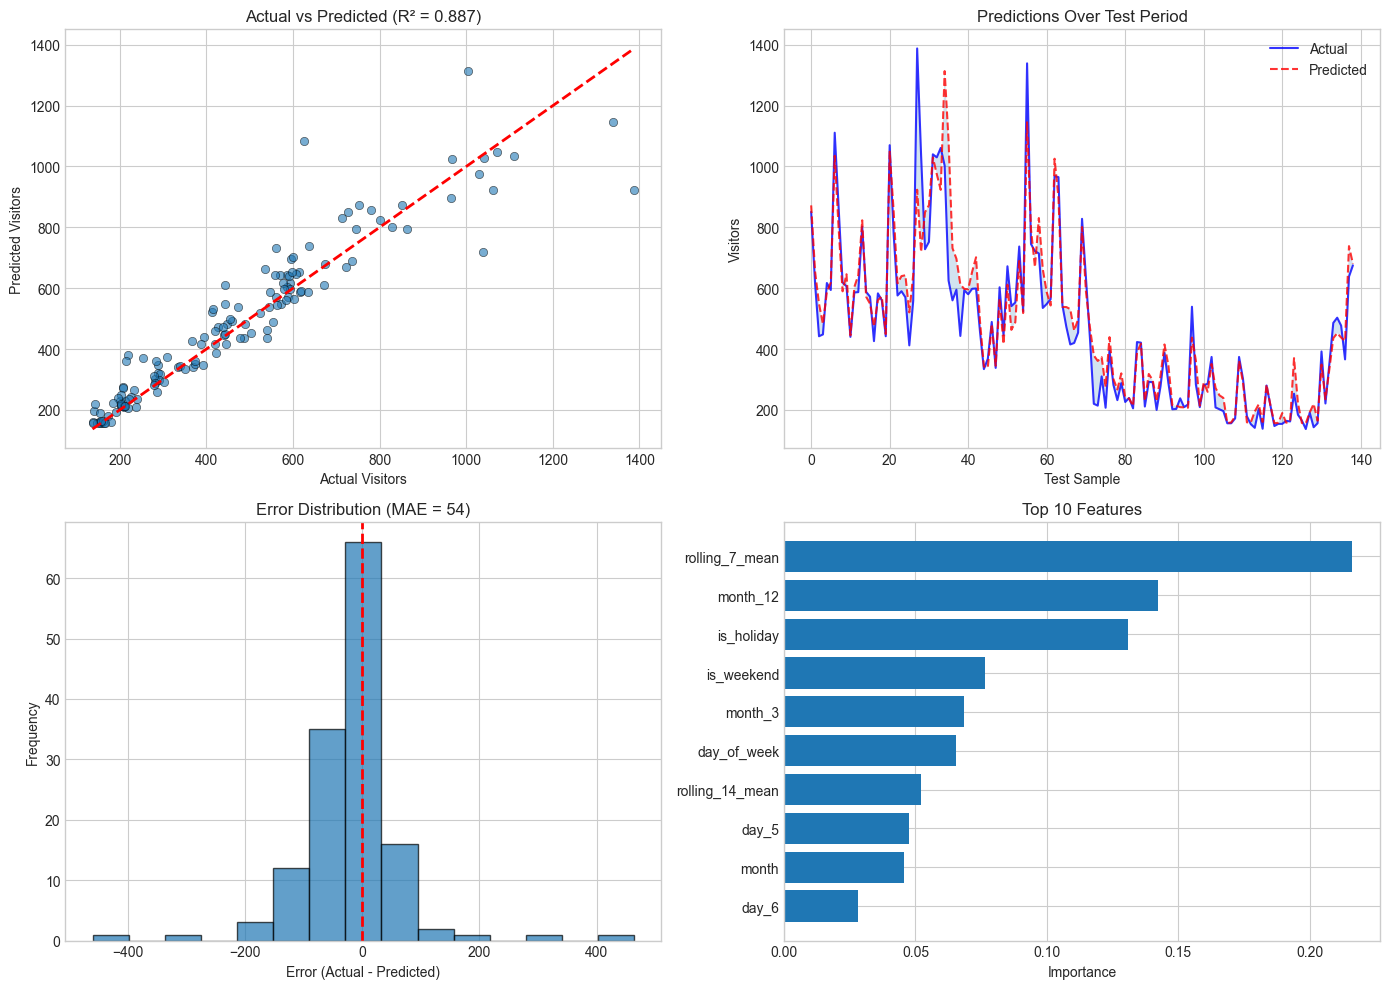

✅ Model: MAE = 54 visitors, R² = 0.887


In [15]:
# Visualize model results
y_pred = model.predict(X_test_np)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Actual vs Predicted
ax = axes[0, 0]
ax.scatter(y_test_np, y_pred, alpha=0.6, edgecolors='black', linewidth=0.5)
ax.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--', lw=2)
ax.set_xlabel('Actual Visitors')
ax.set_ylabel('Predicted Visitors')
ax.set_title(f'Actual vs Predicted (R² = {test_metrics["r2"]:.3f})')

# 2. Time series
ax = axes[0, 1]
ax.plot(range(len(y_test_np)), y_test_np, 'b-', label='Actual', alpha=0.8)
ax.plot(range(len(y_pred)), y_pred, 'r--', label='Predicted', alpha=0.8)
ax.fill_between(range(len(y_test_np)), y_test_np, y_pred, alpha=0.2)
ax.set_xlabel('Test Sample')
ax.set_ylabel('Visitors')
ax.set_title('Predictions Over Test Period')
ax.legend()

# 3. Residuals
ax = axes[1, 0]
residuals = y_test_np - y_pred
ax.hist(residuals, bins=15, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', lw=2)
ax.set_xlabel('Error (Actual - Predicted)')
ax.set_ylabel('Frequency')
ax.set_title(f'Error Distribution (MAE = {test_metrics["mae"]:.0f})')

# 4. Feature importance (top 10)
ax = axes[1, 1]
importance = pd.DataFrame({'feature': feature_cols, 'importance': model.feature_importances_})
importance = importance.sort_values('importance', ascending=True).tail(10)
ax.barh(importance['feature'], importance['importance'])
ax.set_xlabel('Importance')
ax.set_title('Top 10 Features')

plt.tight_layout()
plt.show()

print(f"✅ Model: MAE = {test_metrics['mae']:.0f} visitors, R² = {test_metrics['r2']:.3f}")


## 8. Summary & Next Steps


In [16]:
print("=" * 60)
print("🎿 VISITOR FORECAST MODEL - TRAINING COMPLETE")
print("=" * 60)

print(f"\n📊 Validated Performance (on test set):")
print(f"   MAE:  {test_metrics['mae']:,.0f} visitors (±{test_metrics['mae']/y_test_np.mean()*100:.1f}%)")
print(f"   RMSE: {test_metrics['rmse']:,.0f} visitors")
print(f"   MAPE: {test_metrics['mape']:.1f}%")
print(f"   R²:   {test_metrics['r2']:.4f}")

print(f"\n📦 Registered Model:")
print(f"   Location: SKI_RESORT_DB.MODELS.{MODEL_NAME}")
print(f"   Version: {registered_model.version_name}")
print(f"   Training samples: {len(X_full)} (full dataset)")
print(f"   Best iteration: {model.best_iteration}")

print(f"\n✅ ML Workflow Completed:")
print(f"   1. ✓ Trained on 80% data ({len(X_train_np)} samples)")
print(f"   2. ✓ Validated on 20% holdout ({len(X_test_np)} samples)")
print(f"   3. ✓ Passed quality gate (R² ≥ 0.5, MAE ≤ 200)")
print(f"   4. ✓ Retrained on full data ({len(X_full)} samples)")
print(f"   5. ✓ Registered to Model Registry")

print(f"\n🔜 Next Steps:")
print(f"   1. Create SQL procedure wrapper: model_registry_tools.sql")
print(f"   2. Add procedure as tool to ski_ops_assistant.yml")
print(f"   3. Deploy agent and test with forecasting questions:")
print(f"      - 'How many visitors can we expect next Saturday?'")
print(f"      - 'Forecast visitors for the holiday weekend'")

print("\n" + "=" * 60)


🎿 VISITOR FORECAST MODEL - TRAINING COMPLETE

📊 Validated Performance (on test set):
   MAE:  54 visitors (±11.5%)
   RMSE: 89 visitors
   MAPE: 11.9%
   R²:   0.8865

📦 Registered Model:
   Location: SKI_RESORT_DB.MODELS.VISITOR_FORECASTER
   Version: BRIGHT_JAGUAR_4
   Training samples: 695 (full dataset)
   Best iteration: 95

✅ ML Workflow Completed:
   1. ✓ Trained on 80% data (556 samples)
   2. ✓ Validated on 20% holdout (139 samples)
   3. ✓ Passed quality gate (R² ≥ 0.5, MAE ≤ 200)
   4. ✓ Retrained on full data (695 samples)
   5. ✓ Registered to Model Registry

🔜 Next Steps:
   1. Create SQL procedure wrapper: model_registry_tools.sql
   2. Add procedure as tool to ski_ops_assistant.yml
   3. Deploy agent and test with forecasting questions:
      - 'How many visitors can we expect next Saturday?'
      - 'Forecast visitors for the holiday weekend'

